In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Check if TensorFlow is able to detect a GPU
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Set the GPU device to use
device_name = '/device:GPU:0'

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (_, _) = mnist.load_data()

In [ ]:
#normalize the images to [-1,1]
train_images = (train_images.astype('float32') - 127.5) / 127.5

In [ ]:
#reshape the images to (28, 28, 1) and add a channel direction
train_images = np.expand_dims(train_images, axis=-1)

In [ ]:
# Batch and shuffle the data
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256)
  model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1),padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))

  assert model.output_shape == (None, 14, 14, 64)

  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2),padding='same', use_bias=False, activation='tanh'))

  assert model.output_shape == (None, 28, 28, 1)
  return model

In [ ]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(1))
  return model

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [ ]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
# Define the models
generator = make_generator_model()
discriminator = make_discriminator_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Define the optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# Define the training loop
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

In [ ]:
@tf.function
def train_step(images):
  # Generate noise
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    # Generate fake images
    generated_images = generator(noise, training=True)
    # Evaluate discriminator on real and fake images
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    # Calculate the losses
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
# Calculate the gradients and apply them
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Generate images from the model
  predictions = model(test_input, training=False)
  # Rescale to [0, 1]
  predictions = (predictions + 1) / 2.0
  # Plot the images
  fig = plt.figure(figsize=(4, 4))
  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')
  # Save the figure
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
# Generate a fixed set of noise for evaluating the model during training
fixed_noise = tf.random.normal([num_examples_to_generate, noise_dim])

Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Epoch 4 completed
Epoch 5 completed
Epoch 6 completed
Epoch 7 completed
Epoch 8 completed
Epoch 9 completed


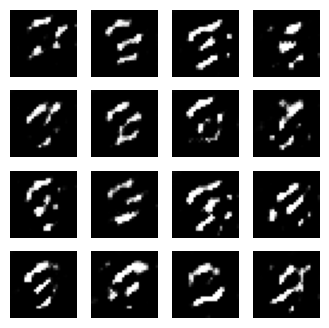

Epoch 10 completed
Epoch 11 completed
Epoch 12 completed
Epoch 13 completed
Epoch 14 completed
Epoch 15 completed
Epoch 16 completed
Epoch 17 completed
Epoch 18 completed
Epoch 19 completed


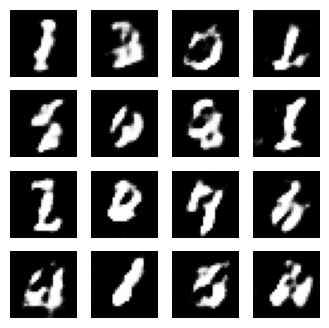

Epoch 20 completed
Epoch 21 completed
Epoch 22 completed
Epoch 23 completed
Epoch 24 completed
Epoch 25 completed
Epoch 26 completed
Epoch 27 completed
Epoch 28 completed
Epoch 29 completed


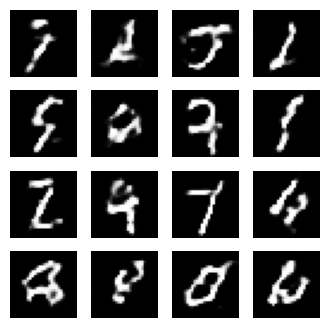

Epoch 30 completed
Epoch 31 completed
Epoch 32 completed
Epoch 33 completed
Epoch 34 completed
Epoch 35 completed
Epoch 36 completed
Epoch 37 completed
Epoch 38 completed
Epoch 39 completed


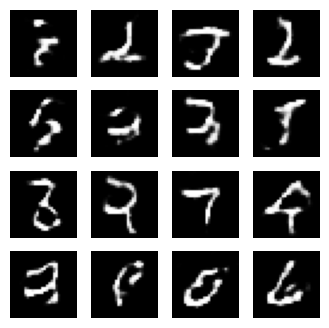

Epoch 40 completed
Epoch 41 completed
Epoch 42 completed
Epoch 43 completed
Epoch 44 completed
Epoch 45 completed
Epoch 46 completed
Epoch 47 completed
Epoch 48 completed
Epoch 49 completed


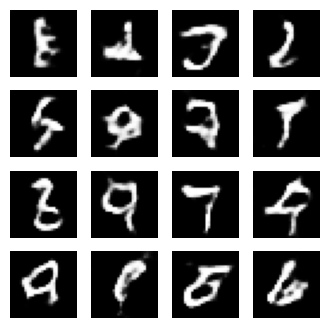

Epoch 50 completed
Epoch 51 completed
Epoch 52 completed
Epoch 53 completed
Epoch 54 completed
Epoch 55 completed
Epoch 56 completed
Epoch 57 completed
Epoch 58 completed
Epoch 59 completed


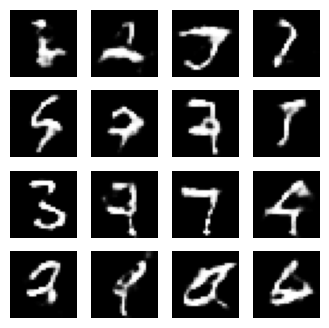

Epoch 60 completed
Epoch 61 completed
Epoch 62 completed
Epoch 63 completed
Epoch 64 completed
Epoch 65 completed
Epoch 66 completed
Epoch 67 completed
Epoch 68 completed
Epoch 69 completed


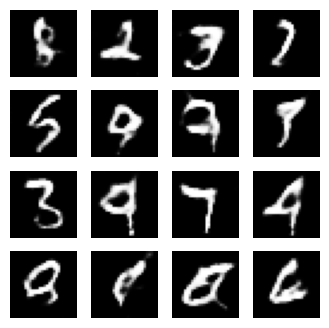

Epoch 70 completed
Epoch 71 completed
Epoch 72 completed
Epoch 73 completed
Epoch 74 completed
Epoch 75 completed
Epoch 76 completed
Epoch 77 completed
Epoch 78 completed
Epoch 79 completed


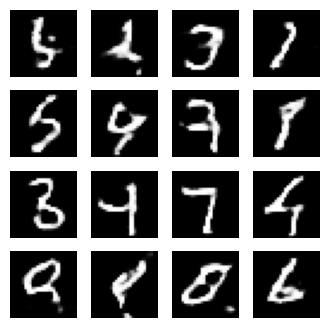

Epoch 80 completed
Epoch 81 completed
Epoch 82 completed
Epoch 83 completed
Epoch 84 completed
Epoch 85 completed
Epoch 86 completed
Epoch 87 completed
Epoch 88 completed
Epoch 89 completed


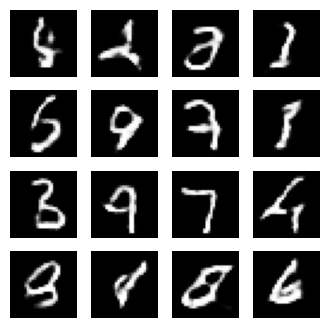

Epoch 90 completed
Epoch 91 completed
Epoch 92 completed
Epoch 93 completed
Epoch 94 completed
Epoch 95 completed
Epoch 96 completed
Epoch 97 completed
Epoch 98 completed
Epoch 99 completed


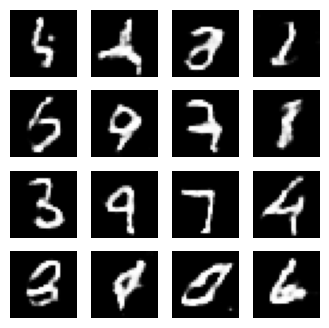

Epoch 100 completed


In [ ]:
# Train the model
for epoch in range(EPOCHS):
  for image_batch in train_dataset:
    train_step(image_batch)
  # Generate and save images every 10 epochs
  if (epoch + 1) % 10 == 0:
    generate_and_save_images(generator, epoch + 1, fixed_noise)
  # Print progress every epoch
  print('Epoch {} completed'.format(epoch + 1))